In [ ]:
import pygame
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import random
import asyncio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque

pygame.init()

class TetrisEnv:
    def __init__(self):
        self.width = 10
        self.height = 20
        self.block_size = 30
        self.screen = pygame.Surface((self.width * self.block_size, self.height * self.block_size + 50))
        self.font = pygame.font.SysFont('Arial', 24)
        self.grid = [[0 for _ in range(self.width)] for _ in range(self.height)]
        self.pieces = [
            [[1, 1, 1, 1]],            # I
            [[1, 1], [1, 1]],          # O
            [[1, 1, 1], [0, 1, 0]],    # T
            [[1, 1, 1], [1, 0, 0]],    # L
            [[1, 1, 1], [0, 0, 1]]     # J
        ]
        self.reset()

    def reset(self):
        """Reset the game state."""
        self.grid = [[0 for _ in range(self.width)] for _ in range(self.height)]
        self.current_piece = np.array(random.choice(self.pieces))
        self.piece_x = self.width // 2 - self.current_piece.shape[1] // 2
        self.piece_y = 0
        self.score = 0
        return self.get_state()

    def get_state(self):
        """Return normalized state features: height, holes, bumpiness."""
        height = max((self.height - y) * any(self.grid[y]) for y in range(self.height)) if any(any(row) for row in self.grid) else 0
        holes = sum(row.count(0) for y in range(self.height) for row in [self.grid[y]] if any(self.grid[y]))
        bumpiness = sum(abs(sum(self.grid[y][x] for y in range(self.height)) -
                            sum(self.grid[y][x+1] for y in range(self.height))) for x in range(self.width-1))
        state = np.array([height / 20.0, holes / 50.0, bumpiness / 100.0], dtype=np.float32)
        return state

    def step(self, action):
        """Execute an action and return next state, reward, and done."""
        lines_cleared = 0
        game_over = False

        if action == 0 and self.can_move(-1, 0):    # Move left
            self.piece_x -= 1
        elif action == 1 and self.can_move(1, 0):   # Move right
            self.piece_x += 1
        elif action == 2:                           # Rotate
            rotated = np.rot90(self.current_piece)
            if self.can_move(0, 0, rotated):
                self.current_piece = rotated
        elif action == 3:                           # Drop
            while self.can_move(0, 1):
                self.piece_y += 1
            lines_cleared, game_over = self.lock_piece()

        if action != 3:
            if self.can_move(0, 1):
                self.piece_y += 1
            else:
                lines_cleared, game_over = self.lock_piece()

        reward = lines_cleared * 100
        if game_over:
            reward -= 100
        done = game_over
        return self.get_state(), reward, done

    def can_move(self, dx, dy, piece=None):
        """Check if the piece can move or rotate."""
        if piece is None:
            piece = self.current_piece
        for y in range(piece.shape[0]):
            for x in range(piece.shape[1]):
                if piece[y][x]:
                    new_x = self.piece_x + x + dx
                    new_y = self.piece_y + y + dy
                    if (new_x < 0 or new_x >= self.width or
                        new_y >= self.height or
                        (new_y >= 0 and self.grid[new_y][new_x])):
                        return False
        return True

    def lock_piece(self):
        """Lock the current piece and spawn a new one."""
        for y in range(self.current_piece.shape[0]):
            for x in range(self.current_piece.shape[1]):
                if self.current_piece[y][x]:
                    self.grid[self.piece_y + y][self.piece_x + x] = 1
        lines_cleared = self.clear_lines()
        self.score += lines_cleared * 100
        self.current_piece = np.array(random.choice(self.pieces))
        self.piece_x = self.width // 2 - self.current_piece.shape[1] // 2
        self.piece_y = 0
        game_over = not self.can_move(0, 0)
        return lines_cleared, game_over

    def clear_lines(self):
        """Clear completed lines and return the count."""
        lines_cleared = 0
        for y in range(self.height - 1, -1, -1):
            if all(self.grid[y]):
                del self.grid[y]
                self.grid.insert(0, [0] * self.width)
                lines_cleared += 1
        return lines_cleared

    def render(self, episode=None):
        """Render the game state as an image with optional episode and score."""
        self.screen.fill((0, 0, 0))
        for y in range(self.height):
            for x in range(self.width):
                if self.grid[y][x]:
                    pygame.draw.rect(self.screen, (255, 255, 255),
                                   (x * self.block_size, y * self.block_size, self.block_size, self.block_size))
        for y in range(self.current_piece.shape[0]):
            for x in range(self.current_piece.shape[1]):
                if self.current_piece[y][x]:
                    pygame.draw.rect(self.screen, (255, 0, 0),
                                   ((self.piece_x + x) * self.block_size,
                                    (self.piece_y + y) * self.block_size,
                                    self.block_size, self.block_size))
        if episode is not None:
            text = self.font.render(f"Episode: {episode}, Score: {self.score}", True, (255, 255, 255))
            self.screen.blit(text, (10, self.height * self.block_size + 10))
        pixels = pygame.surfarray.array3d(self.screen)
        pixels = np.transpose(pixels, (1, 0, 2))
        return Image.fromarray(pixels)



pygame 2.6.1 (SDL 2.28.4, Python 3.11.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = self.build_model()

    def build_model(self):
        """Build the neural network model."""
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def get_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        """Train the model on a batch of experiences."""
        if len(self.memory) < 32:
            return
        batch = random.sample(self.memory, 32)
        states = np.array([exp[0] for exp in batch])
        actions = np.array([exp[1] for exp in batch])
        rewards = np.array([exp[2] for exp in batch])
        next_states = np.array([exp[3] for exp in batch])
        dones = np.array([exp[4] for exp in batch])

        targets = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)
        for i in range(len(batch)):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])
        self.model.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

async def train_agent(episodes):
    env = TetrisEnv()
    state_size = 3  # [height, holes, bumpiness]
    action_size = 4  # [left, right, rotate, drop]
    agent = DQNAgent(state_size, action_size)
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 100
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward
        rewards_per_episode.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    return agent, rewards_per_episode

async def visualize_agent(agent, episodes_to_visualize=10):
    env = TetrisEnv()
    state = env.reset()
    current_episode = 1
    while current_episode <= episodes_to_visualize:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        state = next_state
        img = env.render(current_episode)
        display(img)
        clear_output(wait=True)
        await asyncio.sleep(0.2)
        if done:
            state = env.reset()
            current_episode += 1
    print("Visualization complete.")


# Train the agent
print("Training the agent...")
trained_agent, rewards = await train_agent(episodes=2)  # Adjust episodes as needed

# Visualize the agent's performance
print("\nStarting animation...")
await visualize_agent(trained_agent, episodes_to_visualize=2)

Visualization complete.


In [ ]:
# Train the agent and store the data
print("Training the agent...")
trained_agent, rewards = await train_agent(episodes=10)
print("Training complete. Rewards per episode:", rewards)

Training the agent...
Episode 1/10, Total Reward: 0, Epsilon: 0.93
Episode 2/10, Total Reward: 0, Epsilon: 0.79
Episode 3/10, Total Reward: 0, Epsilon: 0.67
Episode 4/10, Total Reward: 0, Epsilon: 0.61
Episode 5/10, Total Reward: 0, Epsilon: 0.56
Episode 6/10, Total Reward: 0, Epsilon: 0.51
Episode 7/10, Total Reward: 0, Epsilon: 0.47
Episode 8/10, Total Reward: 0, Epsilon: 0.44
Episode 9/10, Total Reward: 0, Epsilon: 0.42
Episode 10/10, Total Reward: 0, Epsilon: 0.38
Training complete. Rewards per episode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


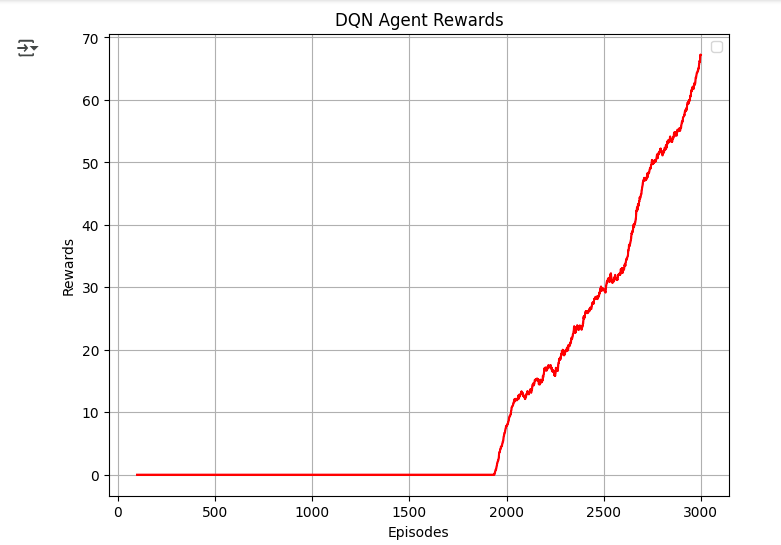

In [ ]:
from IPython.display import Image
Image('/content/DQN-model. PM.png')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import asyncio

# Policy Network for both agents
class PolicyNetwork(tf.keras.Model):
    def __init__(self, action_size):
        super(PolicyNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')

        self.output_layer = Dense(action_size, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

# REINFORCE Agent (Monte Carlo Policy Gradient)
class ReinforceAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.policy = PolicyNetwork(action_size)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
        self.gamma = 0.99

    def get_action(self, state):
        probs = self.policy(state.reshape(1, -1)).numpy()[0]
        action = np.random.choice(self.action_size, p=probs)
        return action

    def train(self, episode):
        states, actions, rewards = zip(*episode)
        states = np.array(states)
        actions = np.array(actions)
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = np.array(returns)

        with tf.GradientTape() as tape:
            probs = self.policy(states)
            selected_probs = tf.gather(probs, actions, batch_dims=1)
            log_probs = tf.math.log(selected_probs)
            loss = -tf.reduce_sum(log_probs * returns)
        grads = tape.gradient(loss, self.policy.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy.trainable_variables))


# Training Functions
async def train_reinforce_agent(episodes):
    env = TetrisEnv()
    state_size = 3    # [height, holes, bumpiness]
    action_size = 4   # Four actions
    agent = ReinforceAgent(state_size, action_size)
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        trajectory = []
        episode_reward = 100
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            episode_reward += reward
        agent.train(trajectory)
        total_rewards.append(episode_reward)
        if (episode + 1) % 100 == 0:
            print(f"REINFORCE Episode {episode+1}/{episodes}, Reward: {episode_reward}")
    return agent, total_rewards


In [ ]:
# PPO Agent
# Value Network for PPO
class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')
        self.output_layer = Dense(1, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

class PPOAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.policy = PolicyNetwork(action_size)
        self.value = ValueNetwork()
        self.policy_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.value_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.gamma = 0.99
        self.epsilon_clip = 0.2
        self.epochs = 10

    def get_action(self, state):
        probs = self.policy(state.reshape(1, -1)).numpy()[0]
        action = np.random.choice(self.action_size, p=probs)
        return action

    def train(self, trajectories):
        for trajectory in trajectories:
            states, actions, rewards, log_probs, next_states, dones = zip(*trajectory)
            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            log_probs = np.array(log_probs)
            next_states = np.array(next_states)
            dones = np.array(dones)

            values = self.value(states).numpy().flatten()
            next_values = self.value(next_states).numpy().flatten()
            advantages = []
            returns = []
            adv = 0
            for t in reversed(range(len(rewards))):
                if dones[t]:
                    delta = rewards[t] - values[t]
                    adv = delta
                else:
                    delta = rewards[t] + self.gamma * next_values[t] - values[t]
                    adv = delta + self.gamma * adv
                advantages.insert(0, adv)
                returns.insert(0, adv + values[t])
            advantages = np.array(advantages)
            returns = np.array(returns)

            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            for _ in range(self.epochs):
                with tf.GradientTape() as policy_tape, tf.GradientTape() as value_tape:
                    current_probs = self.policy(states)
                    current_log_probs = tf.math.log(tf.gather(current_probs, actions, batch_dims=1))
                    ratios = tf.exp(current_log_probs - log_probs)
                    clipped_ratios = tf.clip_by_value(ratios, 1 - self.epsilon_clip, 1 + self.epsilon_clip)
                    policy_loss = -tf.reduce_mean(tf.minimum(ratios * advantages, clipped_ratios * advantages))
                    value_pred = self.value(states)
                    value_loss = tf.reduce_mean((returns - value_pred) ** 2)

                policy_grads = policy_tape.gradient(policy_loss, self.policy.trainable_variables)
                self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy.trainable_variables))
                value_grads = value_tape.gradient(value_loss, self.value.trainable_variables)
                self.value_optimizer.apply_gradients(zip(value_grads, self.value.trainable_variables))

# Training Functions

async def train_ppo_agent(episodes, episodes_per_update=10):
    env = TetrisEnv()
    state_size = 3
    action_size = 4
    agent = PPOAgent(state_size, action_size)
    total_rewards = []

    for update in range(episodes // episodes_per_update):
        trajectories = []
        for _ in range(episodes_per_update):
            state = env.reset()
            done = False
            trajectory = []
            episode_reward = 100
            while not done:
                probs = agent.policy(state.reshape(1, -1)).numpy()[0]
                action = np.random.choice(action_size, p=probs)
                log_prob = np.log(probs[action])
                next_state, reward, done = env.step(action)
                trajectory.append((state, action, reward, log_prob, next_state, done))
                state = next_state
                episode_reward += reward
            trajectories.append(trajectory)
            total_rewards.append(episode_reward)
            if (update * episodes_per_update + len(trajectories)) % 100 == 0:
              print(f"PPO Episode {update * episodes_per_update + len(trajectories)}/{episodes}, Reward: {episode_reward}")
        agent.train(trajectories)
    return agent, total_rewards

In [ ]:
import numpy as np
import asyncio

async def run_experiments():
    print("Training REINFORCE Agent...")
    reinforce_agent, reinforce_rewards = await train_reinforce_agent(episodes=10)

    print("\nTraining PPO Agent...")
    ppo_agent, ppo_rewards = await train_ppo_agent(episodes=10,episodes_per_update=10)


    return reinforce_rewards, ppo_rewards

    # Save rewards for comparison
    np.save('reinforce_rewards.npy', reinforce_rewards)
    np.save('ppo_rewards.npy', ppo_rewards)
    print("Rewards saved as 'reinforce_rewards.npy' and 'ppo_rewards.npy' for comparison.")

# Run the experiments
await run_experiments()

Training REINFORCE Agent...

Training PPO Agent...


([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
reinforce_agent, reinforce_rewards = await train_reinforce_agent(episodes=10)
print("\nVisualizing REINFORCE Agent...")
await visualize_agent(reinforce_agent, episodes_to_visualize=1)

Visualization complete.


In [ ]:
ppo_agent, ppo_rewards = await train_ppo_agent(episodes=10,episodes_per_update=10)
ppo_rewards

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

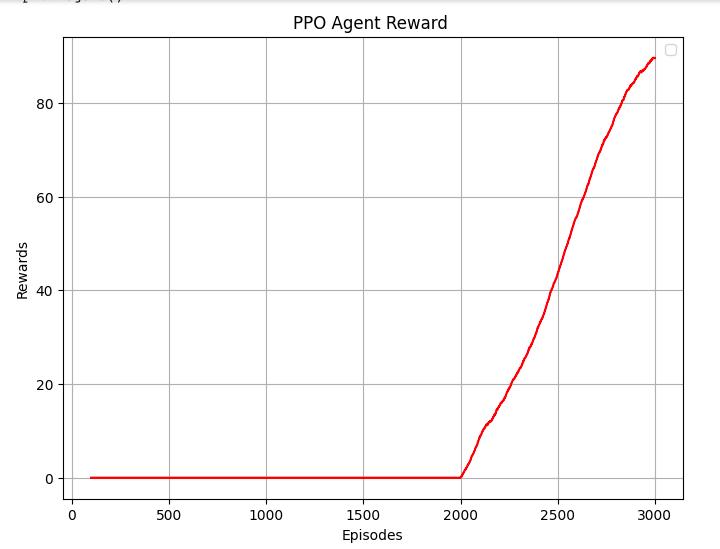

In [ ]:
from IPython.display import Image
Image('/content/PPO-agent.png')

In [ ]:
reinforce_agent, reinforce_rewards = await train_reinforce_agent(episodes=10)
reinforce_rewards

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

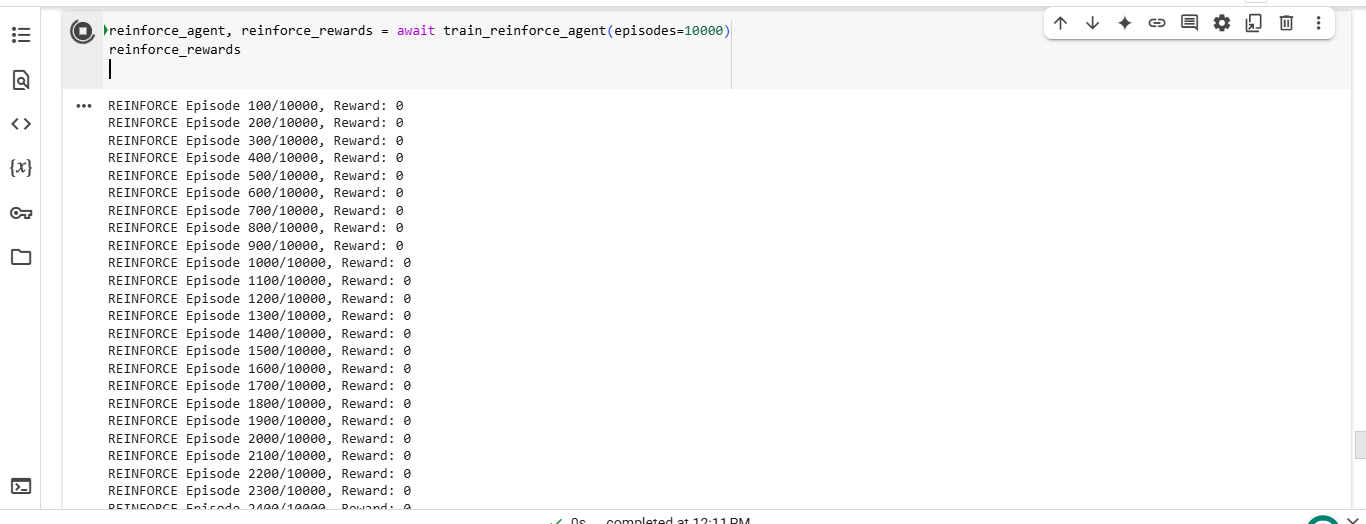

In [ ]:
from IPython.display import Image
Image('/content/reinforce2.png')

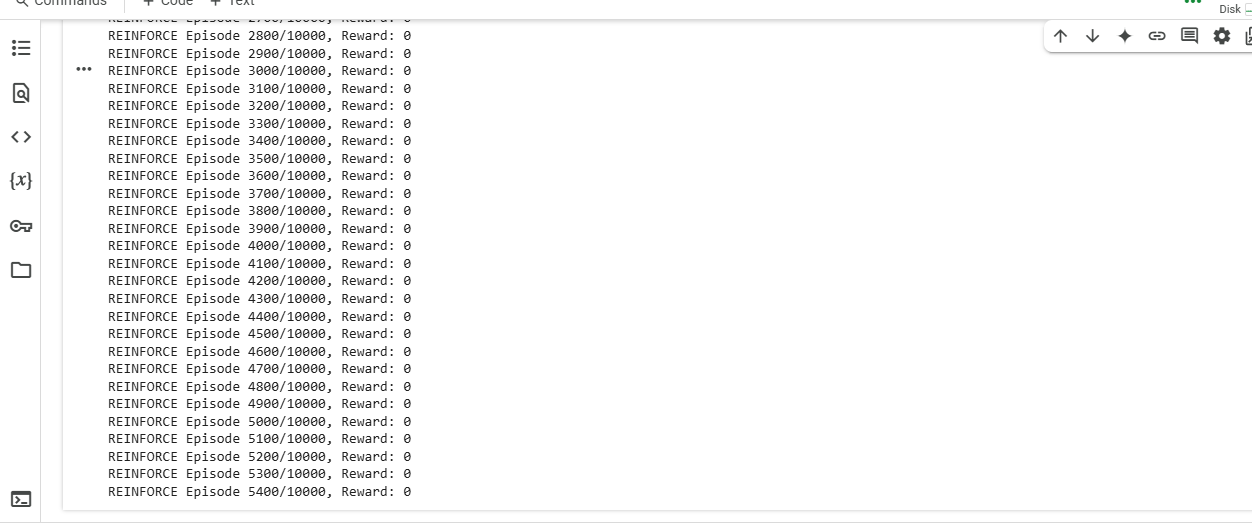

In [ ]:
Image('/content/reinforce2.png')

In [ ]:
import matplotlib.pyplot as plt

episodes = 1000
episodes_per_update = 20

ppo_agent, ppo_rewards = await train_ppo_agent(episodes=1000,episodes_per_update=10)

plt.figure()
plt.plot(range(1, len(ppo_rewards) + 1), ppo_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO_Agent Episode Rewards')
plt.show()


PPO Episode 100/1000, Reward: -100
PPO Episode 200/1000, Reward: -100
PPO Episode 300/1000, Reward: -100
PPO Episode 400/1000, Reward: -100
PPO Episode 500/1000, Reward: -100
PPO Episode 600/1000, Reward: -100
PPO Episode 700/1000, Reward: -100
PPO Episode 800/1000, Reward: -100
PPO Episode 900/1000, Reward: -100


In [ ]:
ppo_agent, ppo_rewards = await train_ppo_agent(episodes=10,episodes_per_update=10)
print("\nVisualizing PPO Agent...")
await visualize_agent(ppo_agent, episodes_to_visualize=1)

Visualization complete.


In [ ]:
# PPO with Baseline and clipping size as 0.4
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import asyncio

# Policy Network (unchanged)
class PolicyNetwork(tf.keras.Model):
    def __init__(self, action_size):
        super(PolicyNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')
        self.output_layer = Dense(action_size, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

# Value Network for baseline
class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')
        self.output_layer = Dense(1, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

# PPO_BL_Agent
class PPO_BL_Agent:
    def __init__(self, state_size, action_size):
        self.state_size     = state_size
        self.action_size    = action_size
        self.policy         = PolicyNetwork(action_size)
        self.value          = ValueNetwork()
        self.policy_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.value_optimizer  = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.gamma          = 0.99
        self.epsilon_clip   = 0.2
        self.epochs         = 10

    def get_action(self, state):
        probs = self.policy(state.reshape(1, -1)).numpy()[0]
        return np.random.choice(self.action_size, p=probs)

    def train(self, trajectories):
        # Aggregate across all trajectories
        states, actions, rewards, old_log_probs, next_states, dones = [], [], [], [], [], []
        for traj in trajectories:
            for (s, a, r, lp, ns, d) in traj:
                states.append(s); actions.append(a)
                rewards.append(r); old_log_probs.append(lp)
                next_states.append(ns); dones.append(d)

        states      = np.array(states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.int32)
        rewards     = np.array(rewards, dtype=np.float32)
        old_log_probs = np.array(old_log_probs, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        dones       = np.array(dones, dtype=bool)

        # Compute returns & advantages using the value baseline
        values      = self.value(states).numpy().flatten()
        next_values = self.value(next_states).numpy().flatten()
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * gae  # GAE(lambda=0.95)
            advantages.insert(0, gae)
            returns.insert(0, gae + values[t])

        advantages = np.array(advantages, dtype=np.float32)
        returns    = np.array(returns, dtype=np.float32)
        # normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update over multiple epochs
        for _ in range(self.epochs):
            with tf.GradientTape() as p_tape, tf.GradientTape() as v_tape:
                # policy loss
                probs      = self.policy(states)
                new_logp   = tf.math.log(tf.gather(probs, actions, batch_dims=1) + 1e-8)
                ratio      = tf.exp(new_logp - old_log_probs)
                clipped    = tf.clip_by_value(ratio, 1 - self.epsilon_clip, 1 + self.epsilon_clip)
                policy_loss= -tf.reduce_mean(tf.minimum(ratio * advantages,
                                                       clipped * advantages))

                # value loss
                value_pred = tf.squeeze(self.value(states), axis=1)
                value_loss = tf.reduce_mean((returns - value_pred) ** 2)

            p_grads = p_tape.gradient(policy_loss, self.policy.trainable_variables)
            v_grads = v_tape.gradient(value_loss,  self.value.trainable_variables)
            self.policy_optimizer.apply_gradients(zip(p_grads, self.policy.trainable_variables))
            self.value_optimizer.apply_gradients(zip(v_grads, self.value.trainable_variables))

# Training function
async def train_ppo_bl_agent(episodes, episodes_per_update=10):
    env = TetrisEnv()
    state_size, action_size = 3, 4
    agent = PPO_BL_Agent(state_size, action_size)
    total_rewards = []
    avg_rewards = []
    episode_count = 0

    for update in range(episodes // episodes_per_update):
        trajectories = []
        for _ in range(episodes_per_update):
            state = env.reset()
            done = False
            traj = []
            ep_reward = 0
            while not done:
                action   = agent.get_action(state)
                probs    = agent.policy(state.reshape(1,-1)).numpy()[0]
                log_prob = np.log(probs[action] + 1e-8)
                next_state, reward, done = env.step(action)
                traj.append((state, action, reward, log_prob, next_state, done))
                state = next_state
                ep_reward += reward

            trajectories.append(traj)
            total_rewards.append(ep_reward)
            episode_count += 1

            if episode_count % 100 == 0:
                avg = sum(total_rewards[-100:]) / 100.0
                avg_rewards.append(avg)
                print(f"Episode {episode_count}/{episodes} — avg reward (last 100): {avg:.2f}")

        agent.train(trajectories)

    return agent, total_rewards, avg_rewards


Episode 100/1000 — avg reward (last 100): -100.00
Episode 200/1000 — avg reward (last 100): -100.00
Episode 300/1000 — avg reward (last 100): -100.00
Episode 400/1000 — avg reward (last 100): -100.00
Episode 500/1000 — avg reward (last 100): -100.00
Episode 600/1000 — avg reward (last 100): -100.00
Episode 700/1000 — avg reward (last 100): -98.00
Episode 800/1000 — avg reward (last 100): -99.00
Episode 900/1000 — avg reward (last 100): -100.00
Episode 1000/1000 — avg reward (last 100): -100.00


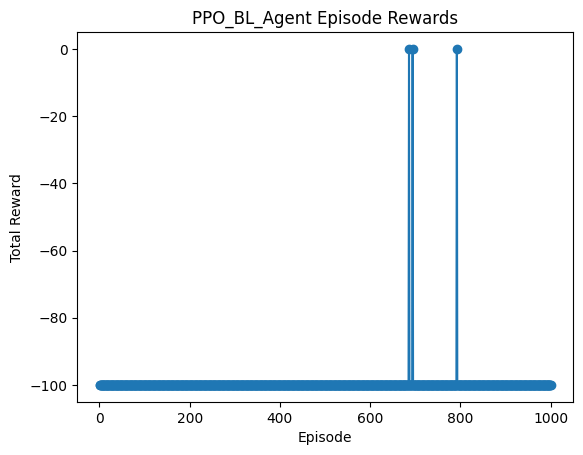

In [ ]:
import matplotlib.pyplot as plt

episodes = 1000
episodes_per_update = 20

agent, total_rewards, avg_rewards = await train_ppo_bl_agent(episodes, episodes_per_update)

plt.figure()
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO_BL_Agent Episode Rewards')
plt.show()


In [ ]:
# PPO with Baseline and clipping size as 0.4
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import asyncio

# Policy Network (unchanged)
class PolicyNetwork(tf.keras.Model):
    def __init__(self, action_size):
        super(PolicyNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')
        self.output_layer = Dense(action_size, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

# Value Network for baseline
class ValueNetwork(tf.keras.Model):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = Dense(24, activation='relu')
        self.dense2 = Dense(24, activation='relu')
        self.output_layer = Dense(1, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

# PPO_BL_Agent
class PPO_BL_Agent:
    def __init__(self, state_size, action_size):
        self.state_size     = state_size
        self.action_size    = action_size
        self.policy         = PolicyNetwork(action_size)
        self.value          = ValueNetwork()
        self.policy_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.value_optimizer  = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.gamma          = 0.99
        self.epsilon_clip   = 0.4
        self.epochs         = 10

    def get_action(self, state):
        probs = self.policy(state.reshape(1, -1)).numpy()[0]
        return np.random.choice(self.action_size, p=probs)

    def train(self, trajectories):
        # Aggregate across all trajectories
        states, actions, rewards, old_log_probs, next_states, dones = [], [], [], [], [], []
        for traj in trajectories:
            for (s, a, r, lp, ns, d) in traj:
                states.append(s); actions.append(a)
                rewards.append(r); old_log_probs.append(lp)
                next_states.append(ns); dones.append(d)

        states      = np.array(states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.int32)
        rewards     = np.array(rewards, dtype=np.float32)
        old_log_probs = np.array(old_log_probs, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        dones       = np.array(dones, dtype=bool)

        # Compute returns & advantages using the value baseline
        values      = self.value(states).numpy().flatten()
        next_values = self.value(next_states).numpy().flatten()
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * 0.95 * gae  # GAE(lambda=0.95)
            advantages.insert(0, gae)
            returns.insert(0, gae + values[t])

        advantages = np.array(advantages, dtype=np.float32)
        returns    = np.array(returns, dtype=np.float32)
        # normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update over multiple epochs
        for _ in range(self.epochs):
            with tf.GradientTape() as p_tape, tf.GradientTape() as v_tape:
                # policy loss
                probs      = self.policy(states)
                new_logp   = tf.math.log(tf.gather(probs, actions, batch_dims=1) + 1e-8)
                ratio      = tf.exp(new_logp - old_log_probs)
                clipped    = tf.clip_by_value(ratio, 1 - self.epsilon_clip, 1 + self.epsilon_clip)
                policy_loss= -tf.reduce_mean(tf.minimum(ratio * advantages,
                                                       clipped * advantages))

                # value loss
                value_pred = tf.squeeze(self.value(states), axis=1)
                value_loss = tf.reduce_mean((returns - value_pred) ** 2)

            p_grads = p_tape.gradient(policy_loss, self.policy.trainable_variables)
            v_grads = v_tape.gradient(value_loss,  self.value.trainable_variables)
            self.policy_optimizer.apply_gradients(zip(p_grads, self.policy.trainable_variables))
            self.value_optimizer.apply_gradients(zip(v_grads, self.value.trainable_variables))

# Training function
async def train_ppo_bl_agent(episodes, episodes_per_update=10):
    env = TetrisEnv()
    state_size, action_size = 3, 4
    agent = PPO_BL_Agent(state_size, action_size)
    total_rewards = []
    avg_rewards = []
    episode_count = 0

    for update in range(episodes // episodes_per_update):
        trajectories = []
        for _ in range(episodes_per_update):
            state = env.reset()
            done = False
            traj = []
            ep_reward = 0
            while not done:
                action   = agent.get_action(state)
                probs    = agent.policy(state.reshape(1,-1)).numpy()[0]
                log_prob = np.log(probs[action] + 1e-8)
                next_state, reward, done = env.step(action)
                traj.append((state, action, reward, log_prob, next_state, done))
                state = next_state
                ep_reward += reward

            trajectories.append(traj)
            total_rewards.append(ep_reward)
            episode_count += 1

            if episode_count % 100 == 0:
                avg = sum(total_rewards[-100:]) / 100.0
                avg_rewards.append(avg)
                print(f"Episode {episode_count}/{episodes} — avg reward (last 100): {avg:.2f}")

        agent.train(trajectories)

    return agent, total_rewards, avg_rewards


Episode 100/1000 — avg reward (last 100): -100.00
Episode 200/1000 — avg reward (last 100): -100.00
Episode 300/1000 — avg reward (last 100): -100.00
Episode 400/1000 — avg reward (last 100): -100.00
Episode 500/1000 — avg reward (last 100): -100.00
Episode 600/1000 — avg reward (last 100): -100.00
Episode 700/1000 — avg reward (last 100): -100.00
Episode 800/1000 — avg reward (last 100): -99.00
Episode 900/1000 — avg reward (last 100): -100.00
Episode 1000/1000 — avg reward (last 100): -100.00


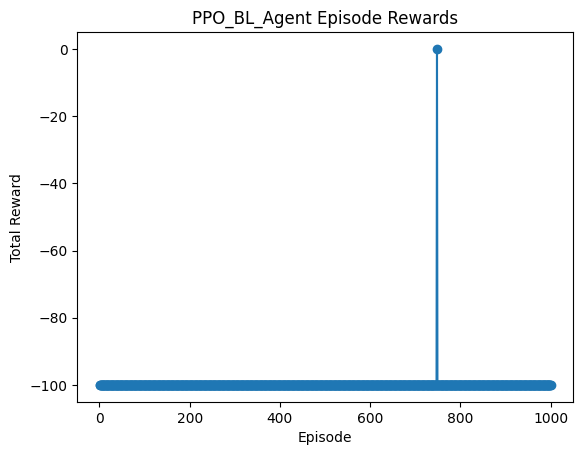

In [ ]:
import matplotlib.pyplot as plt

episodes = 1000
episodes_per_update = 20

agent, total_rewards, avg_rewards = await train_ppo_bl_agent(episodes, episodes_per_update)

plt.figure()
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO_BL_Agent Episode Rewards')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

episodes = 2000
episodes_per_update = 20

agent, total_rewards, avg_rewards = await train_ppo_bl_agent(episodes, episodes_per_update)

plt.figure()
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO_BL_Agent Episode Rewards')
plt.show()


# Acknowledgment
A significant portion of the code for this project was developed with the assistance of large language models (LLMs), which provided guidance on implementation details and debugging.
